# Simplest 1D Gan
Pytorch example of simple 1d Gan

### References
* https://github.com/wiseodd/generative-models/blob/master/GAN/vanilla_gan/gan_pytorch.py
* https://gist.github.com/vvanirudh/8d32f7c2d8ad79aa693101a20b75a451

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data
from scipy.stats import norm
import matplotlib.pyplot as plt

# Include modules from other directories
import sys
sys.path.append('../tensorflow/')
import anim_util as anim

import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

# Fix seed to reproduce same results
seed = 42
np.random.seed(seed)

# Some meta parameters
HIDDEN_SIZE=4
start_lr = 0.005
decay = 0.95
num_steps = 5000
batch_size = 8
num_decay_steps = 150

In [2]:
class DataDistribution(object):
    def __init__(self):
        self.mu = 4
        self.sigma = 0.5

    def sample(self, N):
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort()
        return samples


class GeneratorDistribution(object):
    def __init__(self, range):
        self.range = range

    def sample(self, N):
        return np.linspace(-self.range, self.range, N) + np.random.random(N) * 0.01    

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

In [3]:
def sample_noise(M):
    z = np.float32(np.linspace(-5.0, 5.0, M) + np.random.random(M) * 0.01)
    return z

def plot_decision_boundary(discriminate):
    xs = np.linspace(-5, 5, 1000)
    plt.plot(xs, norm.pdf(xs, loc=mu, scale=sigma), label='p_data')

    r = 1000
    xs = np.float32(np.linspace(-5, 5, r))
    xs_tensor = Variable(torch.from_numpy(xs.reshape(r, 1)))
    ds_tensor = discriminate(xs_tensor)
    ds = ds_tensor.data.numpy()
    plt.plot(xs, ds, label='decision boundary')
    plt.show()


def plot_fig(generate, discriminate, mu=4, sigma=0.5):
    xs = np.linspace(-5, 5, 1000)
    plt.plot(xs, norm.pdf(xs, loc=mu, scale=sigma), label='p_data')

    r = 5000
    xs = np.float32(np.linspace(-5, 5, r))
    xs_tensor = Variable(torch.from_numpy(xs.reshape(r, 1)))
    ds_tensor = discriminate(xs_tensor)
    ds = ds_tensor.data.numpy()
    plt.plot(xs, ds, label='decision boundary')

    zs = sample_noise(r)
    zs_tensor = Variable(torch.from_numpy(np.float32(zs.reshape(r, 1))))
    gs_tensor = generate(zs_tensor)
    gs = gs_tensor.data.numpy()
    plt.hist(gs, bins=10, normed=True)


### Create functions for Generator and Discriminator
Observe that the discriminator on this example is more powerfull than the generator, if the mini-batch feature is not used.

In [4]:
class NetG(nn.Module):
    def __init__(self):
        # Call constructor of base class
        super(NetG, self).__init__()        
        self.fc1 = nn.Linear(1, HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE, 1)

    def forward(self, x):        
        x = F.relu(self.fc1(x))        
        x = self.fc2(x)
        return x

class NetD(nn.Module):
    def __init__(self):
        # Call constructor of base class
        super(NetD, self).__init__()        
        self.fc1 = nn.Linear(1, HIDDEN_SIZE*2)
        self.fc2 = nn.Linear(HIDDEN_SIZE*2, HIDDEN_SIZE*2)
        self.fc3 = nn.Linear(HIDDEN_SIZE*2, HIDDEN_SIZE*2)
        self.fc4 = nn.Linear(HIDDEN_SIZE*2, 1)

    def forward(self, x):        
        x = F.leaky_relu(self.fc1(x))        
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        return x    

modelG = NetG()
modelD = NetD()

### Define Loss function

In [5]:
def generator_loss(d_output_g):
    return -0.5 * torch.mean(torch.log(d_output_g))

def discriminator_loss(d_output_true, d_output_g):
    return -0.5 * torch.mean(torch.log(d_output_true) + torch.log(1 - d_output_g))    

### Define the solver
We want to use the Adam solver to minimize or loss function.

In [6]:
G_solver = optim.Adam(modelG.parameters(), lr=start_lr)
D_solver = optim.Adam(modelD.parameters(), lr=start_lr)

In [7]:
data = DataDistribution()
gen = GeneratorDistribution(range=8)

In [8]:
anim_frames = []
for step in range(num_steps):
    modelD.zero_grad()
    modelG.zero_grad()
    
    # Gather some real data and some latent z values
    x_np = data.sample(batch_size)
    z_np = gen.sample(batch_size)
        
    x_np_tensor = Variable(torch.from_numpy(np.float32(x_np.reshape(8,1))))
    z_np_tensor = Variable(torch.from_numpy(np.float32(z_np.reshape(8,1))))
    
    # Forward propagation 
    g_out = modelG(z_np_tensor)
    d_out_true = modelD(x_np_tensor)
    d_out_g = modelD(g_out)
    
    # Calculate loss and backpropagate
    loss_D = discriminator_loss(d_out_true, d_out_g)
    loss_D.backward()    
    # update discriminator
    D_solver.step()        
    
    # Generator
    z_np = gen.sample(batch_size)
    z_np_tensor = Variable(torch.from_numpy(np.float32(z_np.reshape(8,1))))
    
    g_out = modelG(z_np_tensor)
    d_out_g = modelD(g_out)
    loss_G = generator_loss(d_out_g)
    loss_G.backward()            
    # update generator
    G_solver.step()           
    
    # Handle animation (Make the whole training slow ...)
    #anim_frames.append(anim.samples(D_real, G, x, z, sess, data, gen.range, batch_size))

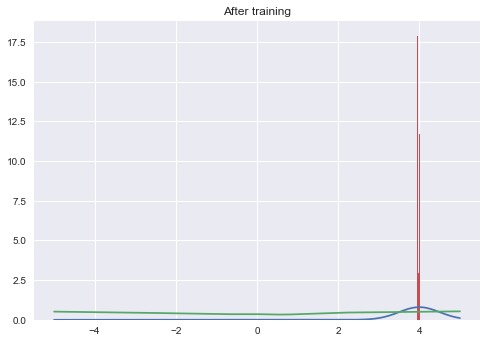

In [9]:
plot_fig(modelG, modelD)
plt.title('After training')
plt.show()

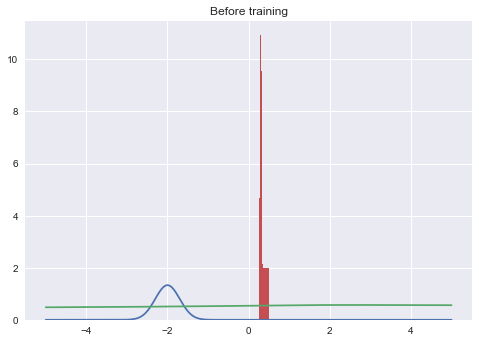

Discriminator loss 0.31069111824
Generator loss 0.654417157173
Discriminator loss 0.005672049243
Generator loss 2.4890601635
Discriminator loss 0.465210527182
Generator loss 0.994343400002
Discriminator loss 0.676807880402
Generator loss 0.602920174599
Discriminator loss 0.684114396572
Generator loss 0.35989060998
Discriminator loss 0.696489810944
Generator loss 0.353318214417
Discriminator loss 0.69362950325
Generator loss 0.348714500666
Discriminator loss 0.694741845131
Generator loss 0.346299797297
Discriminator loss 0.693643629551
Generator loss 0.346356272697
Discriminator loss 0.694606244564
Generator loss 0.346491754055
Discriminator loss 0.693386733532
Generator loss 0.345609754324
Discriminator loss 0.693508148193
Generator loss 0.346991837025
Discriminator loss 0.693539619446
Generator loss 0.345623999834
Discriminator loss 0.693291306496
Generator loss 0.346690535545
Discriminator loss 0.693297088146
Generator loss 0.346387922764
Discriminator loss 0.69331663847
Generator lo

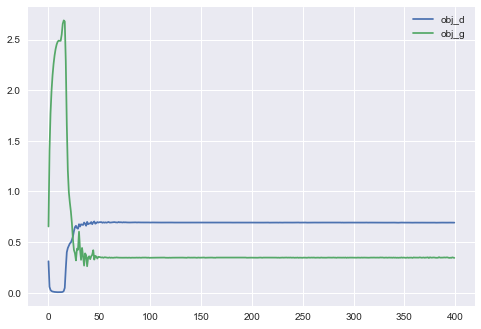

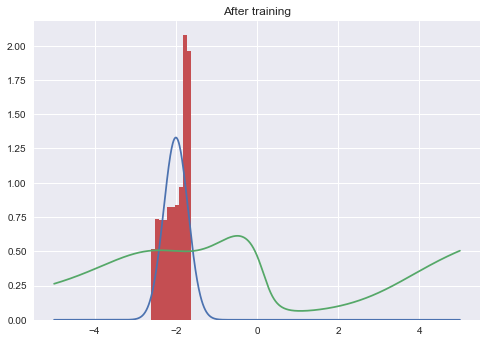

In [10]:
# Drawn from https://gist.github.com/rocknrollnerd/06bfed6b9d1bce612fd6 (in theano)
# This is implemented in PyTorch
# Author : Anirudh Vemula
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.l1 = nn.Linear(1, 10)
        self.l1_relu = nn.ReLU()
        self.l2 = nn.Linear(10, 10)
        self.l2_relu = nn.ReLU()
        self.l3 = nn.Linear(10, 1)

    def forward(self, input):
        output = self.l1(input)
        output = self.l1_relu(output)
        output = self.l2(output)
        output = self.l2_relu(output)
        output = self.l3(output)
        return output


# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.l1 = nn.Linear(1, 10)
        self.l1_tanh = nn.Tanh()
        self.l2 = nn.Linear(10, 10)
        self.l2_tanh = nn.Tanh()
        self.l3 = nn.Linear(10, 1)
        self.l3_sigmoid = nn.Sigmoid()

    def forward(self, input):
        output = self.l1_tanh(self.l1(input))
        output = self.l2_tanh(self.l2(output))
        output = self.l3_sigmoid(self.l3(output))
        return output


def generator_criterion(d_output_g):
    return -0.5 * torch.mean(torch.log(d_output_g))


def discriminator_criterion(d_output_true, d_output_g):
    return -0.5 * torch.mean(torch.log(d_output_true) + torch.log(1 - d_output_g))


mu = -2
sigma = 0.3
M = 200

discriminate = Discriminator()
generate = Generator()

plot_fig(generate, discriminate, mu=mu, sigma=sigma)
plt.title('Before training')
plt.show()

epochs = 400
histd, histg = np.zeros(epochs), np.zeros(epochs)
k = 20

visualize_training = True

plt.ion()

discriminate_optimizer = torch.optim.SGD(discriminate.parameters(), lr=0.1, momentum=0.6)
generate_optimizer = torch.optim.SGD(generate.parameters(), lr=0.01, momentum=0.6)

for i in range(epochs):
    for j in range(k):
        discriminate.zero_grad()
        x = np.float32(np.random.normal(mu, sigma, M))
        z = sample_noise(M)
        z_tensor = Variable(torch.from_numpy(np.float32(z.reshape(M, 1))))
        x_tensor = Variable(torch.from_numpy(np.float32(x.reshape(M, 1))))
        g_out = generate(z_tensor)
        d_out_true = discriminate(x_tensor)
        d_out_g = discriminate(g_out)
        loss = discriminator_criterion(d_out_true, d_out_g)
        loss.backward()
        discriminate_optimizer.step()
        histd[i] = loss.data.numpy()

    generate.zero_grad()
    z = sample_noise(M)
    z_tensor = Variable(torch.from_numpy(np.float32(z.reshape(M, 1))))
    g_out = generate(z_tensor)
    d_out_g = discriminate(g_out)
    loss = generator_criterion(d_out_g)
    loss.backward()
    generate_optimizer.step()
    histg[i] = loss.data.numpy()

    if i % 10 == 0:
        print ('Discriminator loss', histd[i])
        print ('Generator loss', histg[i])
        print
        for param_group in generate_optimizer.param_groups:
            param_group['lr'] *= 0.999
        for param_group in discriminate_optimizer.param_groups:
            param_group['lr'] *= 0.999

    if visualize_training:
        plt.clf()
        plot_fig(generate, discriminate)
        plt.draw()

plt.ioff()

plt.clf()
plt.plot(range(epochs), histd, label='obj_d')
plt.plot(range(epochs), histg, label='obj_g')
plt.legend()
plt.show()

plot_fig(generate, discriminate, mu=mu, sigma=sigma)
plt.title('After training')
plt.show()